In [2]:
# 1. Imports and Downloads
import nltk
import re
import string
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
import pandas as pd
import numpy as np

In [ ]:
# Download all needed data
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")

# 2. Setup
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


# 3. POS Tag mapping
def get_wordnet_pos(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
# 4. Cleaning Function with Lemmatization
def clean_message_lemmatized(text):
    text = text.lower()
    text = re.sub(r"http\S+|www.\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))

    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]

    pos_tags = pos_tag(tokens)
    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags
    ]

    return " ".join(lemmatized)

In [9]:
df = pd.read_csv("spam.csv", encoding="latin1")  # or 'ISO-8859-1'

In [11]:
df.rename(columns={"v1": "flag", "v2": "message"}, inplace=True)

In [12]:
# 5. Apply to your DataFrame
df["cleaned_message"] = df["message"].apply(clean_message_lemmatized)
df[["message", "cleaned_message"]].head()

,message,cleaned_message
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


In [13]:
df.to_csv("spam_cleaned.csv", index=False)

# Start LDA

In [ ]:
# !pip install gensim

   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.0 MB 435.7 kB/s eta 0:00:56
   ---------------------------------------- 0.1/24.0 MB 544.7 kB/s eta 0:00:44
   ---------------------------------------- 0.3/24.0 MB 1.8 MB/s eta 0:00:14
   - -------------------------------------- 1.0/24.0 MB 4.8 MB/s eta 0:00:05
   --- ------------------------------------ 2.0/24.0 MB 7.5 MB/s eta 0:00:03
   --- ------------------------------------ 2.2/24.0 MB 7.5 MB/s eta 0:00:03
   ----- ---------------------------------- 3.6/24.0 MB 10.3 MB/s eta 0:00:02
   ------- -------------------------------- 4.4/24.0 MB 11.2 MB/s eta 0:00:02
   ------- -------------------------------- 4.4/24.0 MB 11.2 MB/s eta 0:00:02
   ------- -------------------------------- 4.5/24.0 MB 10.0 MB/s eta 0:00:02
   ---------- ----------------------------- 6.1/24.0 MB 11.9 MB/s eta 0:00:02
   -


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [16]:
from gensim import corpora, models

In [17]:
texts = df["cleaned_message"].astype(str).apply(word_tokenize).tolist()
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

Save the dictionary, the corpus and the tokens

In [ ]:
import pickle

# Save tokenized texts
with open("sms_tokenized.pkl", "wb") as f:
    pickle.dump(texts, f)

# Save dictionary
dictionary.save("sms_dictionary.dict")

# Save corpus
corpora.MmCorpus.serialize("sms_corpus.mm", corpus)

In [2]:
import pickle
from gensim import corpora

# Load texts
with open("sms_tokenized.pkl", "rb") as f:
    texts = pickle.load(f)

# Load dictionary
dictionary = corpora.Dictionary.load("sms_dictionary.dict")

# Load corpus
corpus = corpora.MmCorpus("sms_corpus.mm")

In [1]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDelta
import torch
import numpy as np

In [3]:
num_docs = len(corpus)
vocab_size = len(dictionary)

# Initialize an empty matrix
X = np.zeros((num_docs, vocab_size), dtype=np.float32)

# Fill matrix with BoW data
for doc_idx, doc in enumerate(corpus):
    for word_id, count in doc:
        X[doc_idx, word_id] = count

X_tensor = torch.tensor(X, dtype=torch.float)

# Fast check
num_docs, vocab_size = X_tensor.shape
print("X_tensor shape:", X_tensor.shape)
print("Example doc vector:", X_tensor[0])

X_tensor shape: torch.Size([5572, 7487])
Example doc vector: tensor([1., 1., 1.,  ..., 0., 0., 0.])


In [4]:
# Define the model
# Parametri
K = 5  # num_topics
num_docs, vocab_size = X_tensor.shape


def lda_model(data):
    with pyro.plate("topics", K):
        topic_words = pyro.sample("topic_words", dist.Dirichlet(torch.ones(vocab_size)))

    with pyro.plate("documents", num_docs):
        doc_topics = pyro.sample("doc_topics", dist.Dirichlet(torch.ones(K)))

        # Compute word distributions for all documents
        word_dists = torch.matmul(
            doc_topics, topic_words
        )  # shape: [num_docs, vocab_size]
        word_dists = word_dists / word_dists.sum(
            dim=1, keepdim=True
        )  # normalize each row

        total_count = 100  # fixed number of words for all documents

        pyro.sample(
            "doc_words",
            dist.Multinomial(total_count=total_count, probs=word_dists),
            obs=data,
        )

In [5]:
guide = AutoDelta(lda_model)
optimizer = pyro.optim.Adam({"lr": 0.01})
svi = SVI(lda_model, guide, optimizer, loss=Trace_ELBO())

In [ ]:
num_steps = 500
for step in range(num_steps):
    loss = svi.step(X_tensor)
    if step % 10 == 0:
        print(f"[step {step}] loss = {loss:.2f}")

[step 0] loss = 51225.38
[step 10] loss = 45125.07
[step 20] loss = 39319.63
[step 30] loss = 33801.63
[step 40] loss = 28508.13
[step 50] loss = 23325.07
[step 60] loss = 18115.01
[step 70] loss = 12782.51
[step 80] loss = 7355.16
[step 90] loss = 2000.04
[step 100] loss = -3061.31
[step 110] loss = -7667.46
[step 120] loss = -11761.81
[step 130] loss = -15364.56
[step 140] loss = -18528.37
[step 150] loss = -21312.28
[step 160] loss = -23771.87
[step 170] loss = -25955.84
[step 180] loss = -27905.71
[step 190] loss = -29655.31
[step 200] loss = -31230.84
[step 210] loss = -32652.84
[step 220] loss = -33937.99
[step 230] loss = -35101.24
[step 240] loss = -36156.96
[step 250] loss = -37119.74
[step 260] loss = -38003.40
[step 270] loss = -38817.99
[step 280] loss = -39569.03
[step 290] loss = -40259.37
[step 300] loss = -40892.18
[step 310] loss = -41471.99
[step 320] loss = -42004.56
[step 330] loss = -42494.40
[step 340] loss = -42943.99
[step 350] loss = -43355.96
[step 360] loss =

In [ ]:
posterior = guide()
doc_topics = posterior["doc_topics"]  # shape: [num_docs, K]

topic_df = pd.DataFrame(
    doc_topics.detach().numpy(), columns=[f"topic_{i}" for i in range(K)]
)
df_with_topics = pd.concat([df.reset_index(drop=True), topic_df], axis=1)

### Topic Coherence Evaluation (number of topics)

Choose the num_topics with the highest coherence value

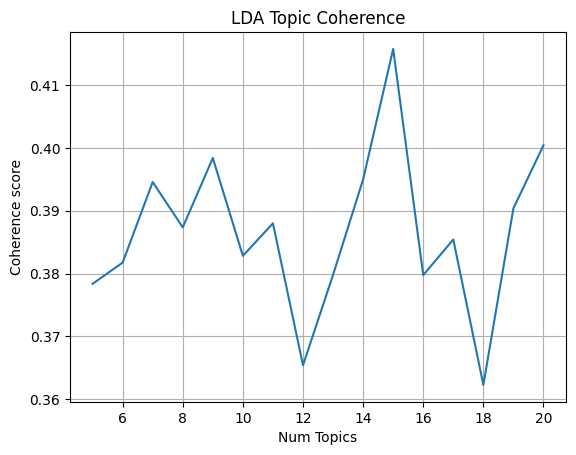

In [25]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt


def compute_coherence_values(dictionary, corpus, texts, start=5, limit=20, step=1):
    coherence_values = []
    models_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            alpha="auto",
        )
        models_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence="c_v"
        )
        coherence_values.append(coherencemodel.get_coherence())
    return models_list, coherence_values


# Compute
model_list, coherence_values = compute_coherence_values(
    dictionary, corpus, texts, start=5, limit=21, step=1
)

# Plot
x = range(5, 21)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("LDA Topic Coherence")
plt.grid()
plt.show()

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Choose the best model from your coherence test or use lda_model
best_model = model_list[coherence_values.index(max(coherence_values))]
vis_data = gensimvis.prepare(best_model, corpus, dictionary)
pyLDAvis.show(vis_data)

### Re-run with optimal number of topics

In [26]:
best_num_topics = 15
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=best_num_topics,
    random_state=42,
    passes=10,
    alpha="auto",
)

In [28]:
!pip install pyLDAvis

   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.6 MB 1.3 MB/s eta 0:00:02
   -------- ------------------------------- 0.6/2.6 MB 4.5 MB/s eta 0:00:01
   ----------------- ---------------------- 1.1/2.6 MB 7.2 MB/s eta 0:00:01
   --------------------------- ------------ 1.8/2.6 MB 8.1 MB/s eta 0:00:01
   -------------------------------- ------- 2.1/2.6 MB 8.9 MB/s eta 0:00:01
   -------------------------------------- - 2.5/2.6 MB 8.0 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 7.5 MB/s eta 0:00:00
Using cached funcy-2.0-py2.py3-none-any.whl (30 kB)
   ---------------------------------------- 0.0/145.0 kB ? eta -:--:--
   ---------------------------------------- 145.0/145.0 kB 8.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [30]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis


pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

🧠 **Pro Tip**:
You can optionally use:

- TF-IDF weighting: to reduce effect of common words
- n-grams: e.g. "free entry", "click here"
- Lemmatization over stemming: for cleaner tokens



In [32]:
import pandas as pd

# Get topic proportions for each document
topic_vectors = []
for bow in corpus:
    topic_dist = lda_model.get_document_topics(bow, minimum_probability=0)
    topic_vector = [prob for _, prob in topic_dist]
    topic_vectors.append(topic_vector)

# Turn into DataFrame
topic_df = pd.DataFrame(
    topic_vectors, columns=[f"topic_{i}" for i in range(lda_model.num_topics)]
)

# Combine with original labels
df_with_topics = pd.concat([df.reset_index(drop=True), topic_df], axis=1)

# Save to file
df_with_topics.to_csv("sms_with_lda_topics.csv", index=False)